In [1]:
!pip install datasets wandb evaluate rouge_score
!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 10.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.3 MB/s eta 0:00:00
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=ab9398691c07ae4bf6253d623de75c7bb8ad5369ab437286633108f8b66e3d9b
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score
     ━━

In [2]:
import wandb
import os

import numpy as np
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')

import re
import torch
from transformers import RobertaTokenizer, T5ForConditionalGeneration
from transformers import DataCollatorForSeq2Seq

from datasets import load_dataset
import evaluate

from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
from huggingface_hub import notebook_login

notebook_login()

W&B integration with 🤗 Hugging Face

In [4]:
wandb.login()

# set the wandb project where this run will be logged
os.environ["WANDB_PROJECT"]="sodabot-sql"

# save your trained model checkpoint to wandb
os.environ["WANDB_LOG_MODEL"]="true"

# turn off watch to log faster
os.environ["WANDB_WATCH"]="false"

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# Model

We're going to use an encoder-decoder model (also called sequence-to-sequence models) that use both parts of the Transformer architecture. At each stage, the attention layers of the encoder can access all the words in the initial sentence, whereas the attention layers of the decoder can only access the words positioned before a given word in the input.

## CodeT5 (small-sized model)

Pre-trained CodeT5 model. It was introduced in the paper [CodeT5: Identifier-aware Unified Pre-trained Encoder-Decoder Models
for Code Understanding and Generation](https://arxiv.org/abs/2109.00859) by Yue Wang, Weishi Wang, Shafiq Joty, Steven C.H. Hoi and first released in [this repository](https://github.com/salesforce/CodeT5).


In [5]:
checkpoint = 'Salesforce/codet5-small'
tokenizer = RobertaTokenizer.from_pretrained(checkpoint)
model = T5ForConditionalGeneration.from_pretrained(checkpoint)

print(f"Context window: {tokenizer.model_max_length} tokens")
print(f"Model size: {model.num_parameters()} parameters")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.48k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/703k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/294k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/12.5k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.57k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/242M [00:00<?, ?B/s]

Context window: 512 tokens
Model size: 60492288 parameters


# Data

To transfer the knowledge of CodeT5 to SQL query generation, we're going to use [b-mc2](https://huggingface.co/datasets/b-mc2/sql-create-context). This dataset includes 78,577 examples of natural language queries, SQL CREATE TABLE statements, and SQL Query answering the question using the CREATE statement as context.

In [6]:
raw_datasets = load_dataset('b-mc2/sql-create-context', split='train')
# Socrata SQL can't seem to handle complex subqueries, so we're only going to use single table queries
raw_datasets = raw_datasets.filter(lambda row: len(re.findall(r" FROM \w+", row['answer'])) == 1)
# Randomly sample 50% of the dataset
raw_datasets = raw_datasets.shuffle(seed=42).shard(2, 0, contiguous=True)
raw_datasets

Generating train split: 0 examples [00:00, ? examples/s]

Filter:   0%|          | 0/78577 [00:00<?, ? examples/s]

Dataset({
    features: ['context', 'question', 'answer'],
    num_rows: 38957
})

In [7]:
# Apply an 80:20 train-test split
raw_datasets = raw_datasets.train_test_split(train_size=0.8, shuffle=True, seed=42)
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['context', 'question', 'answer'],
        num_rows: 31165
    })
    test: Dataset({
        features: ['context', 'question', 'answer'],
        num_rows: 7792
    })
})

## Helpers

We generally have access just 1 dataset at a time when querying NYC Open Data. Therefore, [Socrata SQL](https://dev.socrata.com/docs/queries/) varies from other SQL dialects in that there's usually no `FROM` clause.

In [8]:
def convert_soql(row):
    """
    Conversion to Socrata SQL dialect by removing
    'FROM <table_name>' clause from the SQL query
    """

    row['labels'] = re.sub(r" FROM \w+", '', row['answer'])
    return row

To allow room for new items to be included as part of the output (e.g., free text descriptions, python plotting functions, etc.), we're going to structure generated response as a JSON payload:

In [9]:
def convert_response_to_json(row):
    """
    Formats the 'answer' feature as a JSON response
    """
    response = {
        'query': row['labels'],
        'plot': ''
        # 'explain': ''
    }
    return {
        'labels': f"""{response}"""
    }

In practice, we won't have access to the original table definitions for NYC Open Data. However, Socrata does provide extensive [table metadata](https://stackoverflow.com/questions/24745820/socrata-get-data-types-of-dataset-columns) through the `api/views` endpoint. E.g., for [NYC 311 Data](https://data.cityofnewyork.us/views/erm2-nwe9.json).

We're going to align the formatting of `b-mc2/sql-create-context` table definitions with the JSON payloads we expect this model to see in practice:

In [10]:
def convert_schema_to_json(row):
    """
    Converts 'CREATE TABLE' schema to JSON format
    """

    reg_grp = re.findall(r"CREATE TABLE (.*) \((.*)\)", row['context'])[0]
    table_name = reg_grp[0]
    fields = list(map(lambda x: x.split(), reg_grp[1].split(', ')))
    return {
        'context': [
            {'dataTypeName': x[1], 'description': table_name, 'fieldName': x[0]} for x in fields
        ]
    }

`Salesforce/codet5-small` is a variant of T5 models, which are known to perform well with inputs that are structured as task descriptions. Hence, we will fine-tune the model on a templated prompt. This allows room for the model to be fine-tuned for new tasks, especially in scenarios where clear delineation between different types of information (like questions and code context) is required.

In [11]:
def format_prompt(row):
    """
    Format table JSON schema and natural language question into templated input prompt
    """

    prompt = f"""Given this table schema:
```
{row['context']}
```
Convert this question to Socrata SQL: '{row['question']}'"""
    row['input'] = prompt
    return row

## Transformations

In [12]:
raw_datasets = raw_datasets.map(convert_soql)
raw_datasets = raw_datasets.map(convert_response_to_json)
raw_datasets = raw_datasets.map(convert_schema_to_json)
raw_datasets = raw_datasets.map(format_prompt)
raw_datasets = raw_datasets.remove_columns(['question', 'context'])
raw_datasets

Map:   0%|          | 0/31165 [00:00<?, ? examples/s]

Map:   0%|          | 0/7792 [00:00<?, ? examples/s]

Map:   0%|          | 0/31165 [00:00<?, ? examples/s]

Map:   0%|          | 0/7792 [00:00<?, ? examples/s]

Map:   0%|          | 0/31165 [00:00<?, ? examples/s]

Map:   0%|          | 0/7792 [00:00<?, ? examples/s]

Map:   0%|          | 0/31165 [00:00<?, ? examples/s]

Map:   0%|          | 0/7792 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['answer', 'labels', 'input'],
        num_rows: 31165
    })
    test: Dataset({
        features: ['answer', 'labels', 'input'],
        num_rows: 7792
    })
})

In [13]:
def tokenize_function(row):
    """
    Tokenizes a single row of data for sequence-to-sequence tasks using specified tokenizer.
    """

    input_encoding = tokenizer(row['input'], truncation=True)
    with tokenizer.as_target_tokenizer():
        target_encoding = tokenizer(row['labels'], truncation=True)

    return {
        'input_ids': input_encoding['input_ids'],
        'attention_mask': input_encoding['attention_mask'],
        'labels': target_encoding['input_ids']
    }

In [14]:
ds_tokenized = raw_datasets.map(tokenize_function, batched=True)
ds_tokenized = ds_tokenized.remove_columns(['answer', 'input'])
ds_tokenized

Map:   0%|          | 0/31165 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3856: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/7792 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 31165
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 7792
    })
})

## EDA

In [15]:
print(tokenizer.decode(ds_tokenized['train'][10]['input_ids']))

<s>Given this table schema:
```
[{'dataTypeName': 'VARCHAR', 'description': 'table_1500146_1', 'fieldName':'scientific_linux_release'}, {'dataTypeName': 'VARCHAR', 'description': 'table_1500146_1', 'fieldName': 'delay'}]
```
Convert this question to Socrata SQL: 'Name the scientific linux release when delay is 28d'</s>


In [16]:
print(tokenizer.decode(ds_tokenized['train'][10]['labels']))

<s>{'query': 'SELECT scientific_linux_release WHERE delay = "28d"', 'plot': ''}</s>


Let's look at the distribution of token lengths in the training data to ensure that we're not exceeding the max context window for the model (512 tokens)

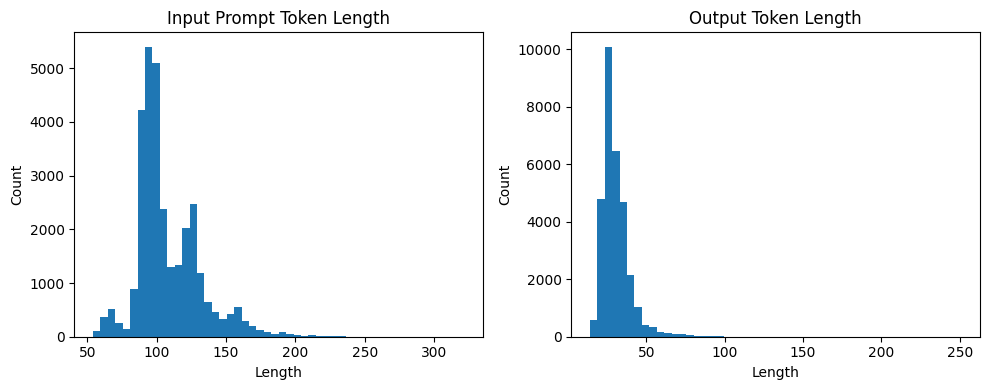

Range input prompt length: 54 - 322
Range output length: 14 - 251


In [17]:
input_token_length = [len(x) for x in ds_tokenized['train']['input_ids']]
output_token_length = [len(x) for x in ds_tokenized['train']['labels']]

fig, axes = plt.subplots(1,2, figsize=(10,4))
axes[0].hist(input_token_length, bins=50)
axes[0].set_title("Input Prompt Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")

axes[1].hist(output_token_length, bins=50)
axes[1].set_title("Output Token Length")
axes[1].set_xlabel("Length")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

print(f"Range input prompt length: {min(input_token_length)} - {max(input_token_length)}")
print(f"Range output length: {min(output_token_length)} - {max(output_token_length)}")

`data_collator` is used for dynamically batching tokenized sequences for seq2seq models. It collates the batches of tokenized inputs (and labels, if provided) into the format required by the `codet5` model during training or evaluation. This includes handling padding, creating attention masks, and ensuring the batched data is correctly processed by the model:

In [18]:
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

# Training

Parameters are passed as [training arguments](https://huggingface.co/docs/transformers/v4.36.1/en/main_classes/trainer#transformers.Seq2SeqTrainingArguments):

In [19]:
training_args = Seq2SeqTrainingArguments(

    report_to = 'wandb',                     # enable logging to W&B
    run_name='codet5-data50pct-v2.0',
    load_best_model_at_end=True,

    output_dir="sql-sodabot-output",
    overwrite_output_dir=True,

    push_to_hub=True,
    hub_model_id='kim-sha/sql-sodabot-v1.0',
    save_strategy="epoch",

    num_train_epochs=25,                     # default = 3
    learning_rate=5e-5,                      # default
    per_device_train_batch_size=64,          # default = 8
    per_device_eval_batch_size=64,           # default = 8
    # weight_decay=0.01,
    # fp16=True,

    evaluation_strategy='epoch',
    # eval_steps=100,
    eval_accumulation_steps=128,
    predict_with_generate=True               # to calculate generative metrics (ROUGE, BLEU)
)

We're going to rely on the [ROUGE](https://huggingface.co/spaces/evaluate-metric/rouge) (Recall-Oriented Understudy for Gisting Evaluation) metric for evaluation.

In [20]:
rouge_metric = evaluate.load("rouge")

def compute_metrics(eval_preds):
    preds, labels = eval_preds

    # decode preds and labels
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # rougeLSum expects newline after each sentence
    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]

    result = rouge_metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    return result

In [21]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=ds_tokenized["train"],
    eval_dataset=ds_tokenized["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics # for custom metrics
)

In [22]:
results = trainer.evaluate()
results

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


wandb: Currently logged in as: kim-sha. Use `wandb login --relogin` to force relogin


{'eval_loss': 6.605640411376953,
 'eval_rouge1': 0.12940187668237532,
 'eval_rouge2': 0.041643731161565035,
 'eval_rougeL': 0.12812461091198996,
 'eval_rougeLsum': 0.12806976972231254,
 'eval_runtime': 238.8675,
 'eval_samples_per_second': 32.621,
 'eval_steps_per_second': 0.511}

In [23]:
trainer.train()

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
1,No log,0.109039,0.841332,0.800427,0.838507,0.838576
2,0.288800,0.085888,0.844015,0.807540,0.841762,0.841764
3,0.116700,0.079353,0.846781,0.811637,0.844808,0.844831
4,0.090400,0.073554,0.846415,0.812375,0.844003,0.844079
5,0.075600,0.067078,0.847087,0.814450,0.845023,0.845077
6,0.065700,0.065660,0.847553,0.815684,0.845767,0.845763
7,0.058200,0.063011,0.847103,0.815535,0.845119,0.845104
8,0.051300,0.062886,0.848241,0.817344,0.846448,0.846475
9,0.046900,0.060591,0.848607,0.818098,0.846674,0.846708
10,0.042900,0.059551,0.848420,0.817944,0.846745,0.846753


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control

TrainOutput(global_step=12175, training_loss=0.05097839408341864, metrics={'train_runtime': 8923.3078, 'train_samples_per_second': 87.313, 'train_steps_per_second': 1.364, 'total_flos': 3.817346358932275e+16, 'train_loss': 0.05097839408341864, 'epoch': 25.0})

In [24]:
wandb.finish()

eval/loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/rouge1,▁█████████████████████████
eval/rouge2,▁█████████████████████████
eval/rougeL,▁█████████████████████████
eval/rougeLsum,▁█████████████████████████
eval/runtime,▂▂▁▅█▇▆▅▅▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/samples_per_second,▇▇▇▄▁▂▃▄▄██▇███████▇██████
eval/steps_per_second,▇▇█▄▁▂▃▄▄██▇██████████████
train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train/learning_rate,██▇▇▇▆▆▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▁▁


## Inference

In [25]:
text = """Given this table schema:
```
[{'dataTypeName': 'VARCHAR', 'description': 'table_name_80', 'fieldName': 'assist_pass'}, {'dataTypeName': 'VARCHAR', 'description': 'table_name_80', 'fieldName': 'location'}]
```
Convert this question to Socrata SQL: 'Which assist/pass is in Ferreiras?'"""

input_ids = tokenizer(text, return_tensors="pt").input_ids.to("cuda")#.to("mps")

# simply generate a single sequence
generated_ids = model.generate(input_ids, max_length=1000)
# Expected: SELECT assist_pass WHERE location = "ferreiras"
print(tokenizer.decode(generated_ids[0], skip_special_tokens=True))

{'query': 'SELECT assist_pass WHERE location = "ferreiras"', 'plot': ''}
